In [1]:
# ----------------------------
# Required Libraries
# ----------------------------
#!pip install neurokit2 pandas scikit-learn xgboost
import numpy as np
import pandas as pd
import neurokit2 as nk
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import joblib
import warnings
warnings.filterwarnings('ignore')  # suppress warnings

In [2]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
#from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, classification_report

In [3]:
# Load the dataset 
file_name = "all_users_hrv_1min5min.csv" 
df = pd.read_csv(file_name) 
df.head()

,HR_1,RMSSD_1,HR_2,RMSSD_2,HR_3,RMSSD_3,HR_4,RMSSD_4,HR_5,RMSSD_5,LF,HF,LF/HF,label,window_index,user_id
0,94.798922,25.791809,91.771316,18.622031,94.612925,10.425721,101.454177,15.038602,99.929593,39.809667,0.003472,0.000802,4.328250,1,1,S10
1,95.960333,12.881016,101.983828,7.294212,106.153397,4.948717,98.694251,12.676475,103.013672,20.204061,0.003893,0.000889,4.377799,1,2,S10
2,98.367781,20.035576,103.863053,14.185221,100.219335,14.642057,94.548799,24.495803,99.917464,14.511471,0.019949,0.002636,7.566943,1,3,S10
3,95.544638,17.025971,90.853851,22.457443,96.430384,12.336644,103.470763,8.349315,96.577431,41.533511,0.003170,0.000569,5.566689,1,4,S10
4,99.762470,12.659643,97.348979,25.765196,81.909266,41.537551,79.915220,37.975315,75.383832,36.446506,0.001882,0.000653,2.880736,0,5,S10


In [4]:
# HR features
hr_columns = [col for col in df.columns if col.startswith("HR_")]
df["HR_avg"] = df[hr_columns].mean(axis=1)
df["HR_max"] = df[hr_columns].max(axis=1)
df["HR_min"] = df[hr_columns].min(axis=1)
df["HR_range"] = df["HR_max"] - df["HR_min"]

# RMSSD features
rmssd_columns = [col for col in df.columns if col.startswith("RMSSD_")]
df["RMSSD_avg"] = df[rmssd_columns].mean(axis=1)
df["RMSSD_max"] = df[rmssd_columns].max(axis=1)
df["RMSSD_min"] = df[rmssd_columns].min(axis=1)
df["RMSSD_range"] = df["RMSSD_max"] - df["RMSSD_min"]

# Optional: check the new dataframe
df.head()

,HR_1,RMSSD_1,HR_2,RMSSD_2,HR_3,RMSSD_3,HR_4,RMSSD_4,HR_5,RMSSD_5,...,window_index,user_id,HR_avg,HR_max,HR_min,HR_range,RMSSD_avg,RMSSD_max,RMSSD_min,RMSSD_range
0,94.798922,25.791809,91.771316,18.622031,94.612925,10.425721,101.454177,15.038602,99.929593,39.809667,...,1,S10,96.513387,101.454177,91.771316,9.682860,21.937566,39.809667,10.425721,29.383946
1,95.960333,12.881016,101.983828,7.294212,106.153397,4.948717,98.694251,12.676475,103.013672,20.204061,...,2,S10,101.161096,106.153397,95.960333,10.193065,11.600896,20.204061,4.948717,15.255344
2,98.367781,20.035576,103.863053,14.185221,100.219335,14.642057,94.548799,24.495803,99.917464,14.511471,...,3,S10,99.383286,103.863053,94.548799,9.314253,17.574026,24.495803,14.185221,10.310582
3,95.544638,17.025971,90.853851,22.457443,96.430384,12.336644,103.470763,8.349315,96.577431,41.533511,...,4,S10,96.575414,103.470763,90.853851,12.616912,20.340577,41.533511,8.349315,33.184197
4,99.762470,12.659643,97.348979,25.765196,81.909266,41.537551,79.915220,37.975315,75.383832,36.446506,...,5,S10,86.863953,99.762470,75.383832,24.378639,30.876842,41.537551,12.659643,28.877908


In [5]:
# 1. Filter relevant labels
df_filtered = df[df['label'].isin([0,1,2])].reset_index(drop=True)

In [6]:
# Combine Transient (0) and Baseline (1) into Non-Stress (0)
df_filtered['label'] = df_filtered['label'].replace({0: 0, 1: 0, 2: 1})

# Optional: check new class distribution
print(df_filtered['label'].value_counts())

label
0    188
1     34
Name: count, dtype: int64


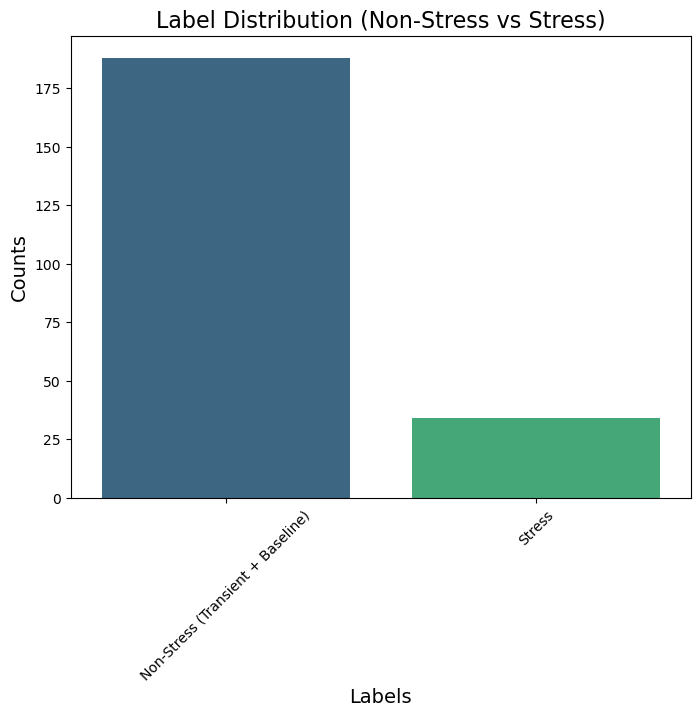

In [7]:
# Count labels after combining
label_counts = df_filtered['label'].value_counts().sort_index()

# Map labels to meaningful names for binary classes
label_mapping = {
    0: 'Non-Stress (Transient + Baseline)',
    1: 'Stress'
}

# Plot bar chart
plt.figure(figsize=(8, 6))
sns.barplot(
    x=[label_mapping[i] for i in label_counts.index],
    y=label_counts.values,
    palette='viridis'
)

plt.title('Label Distribution (Non-Stress vs Stress)', fontsize=16)
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xticks(rotation=45)
plt.show()

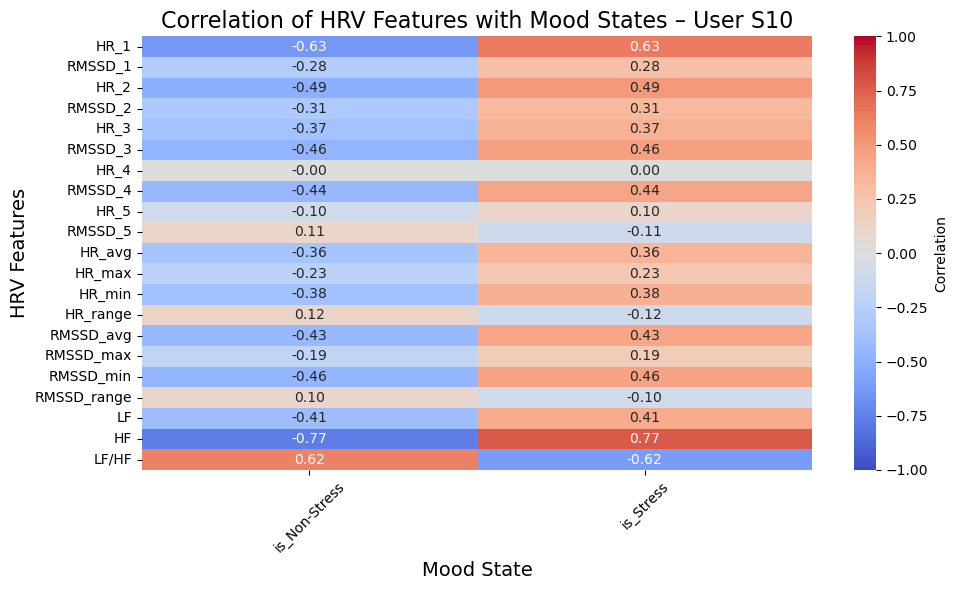

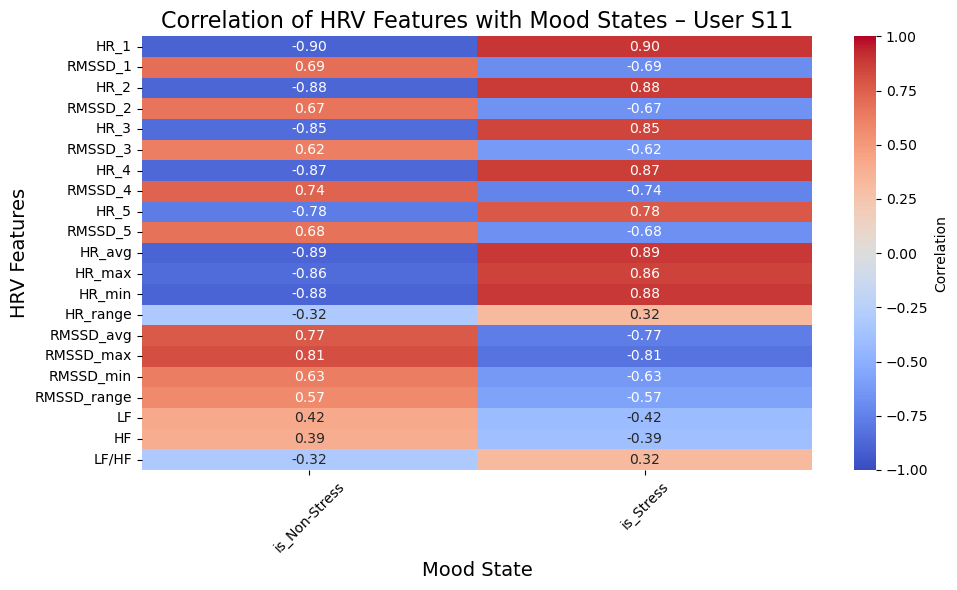

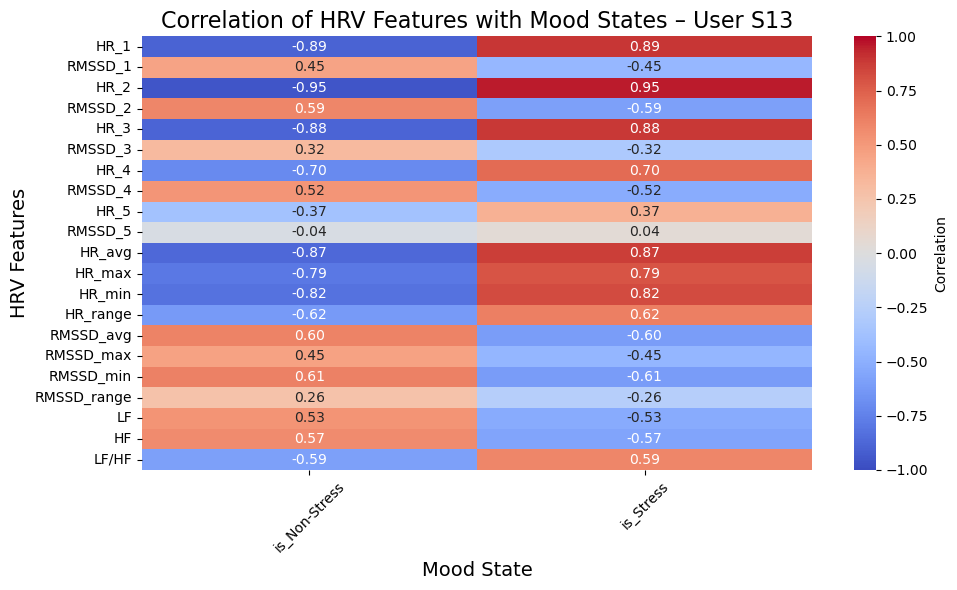

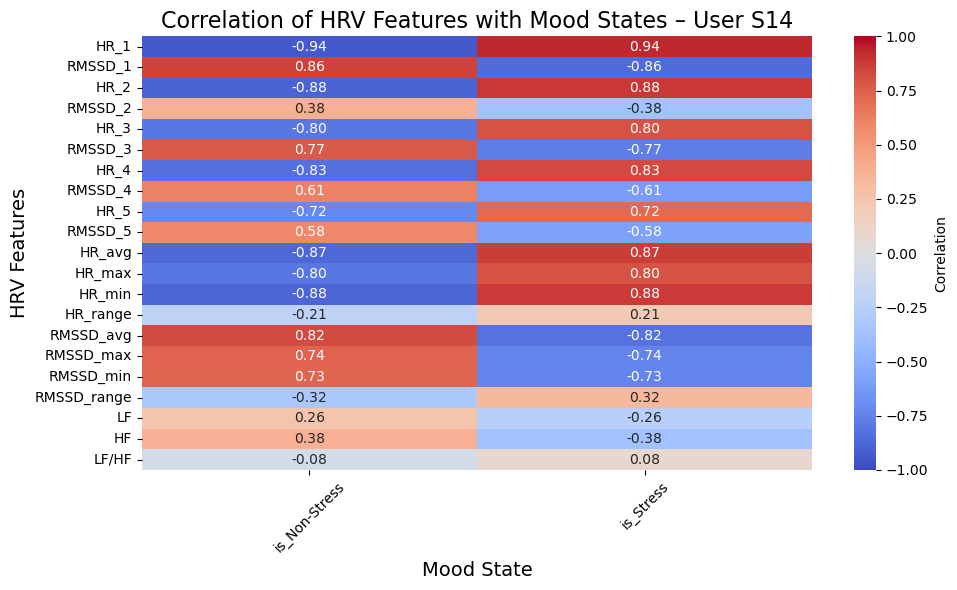

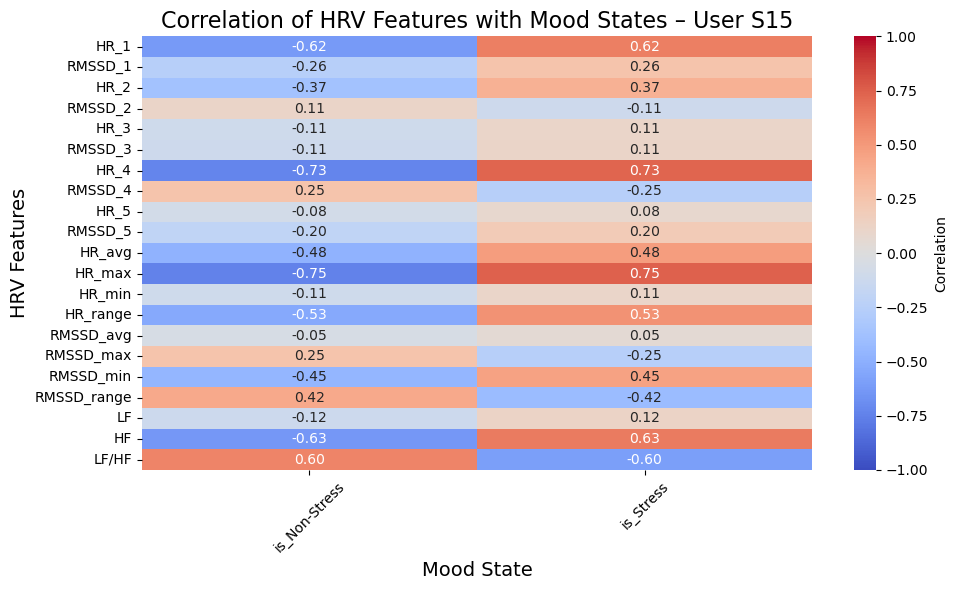

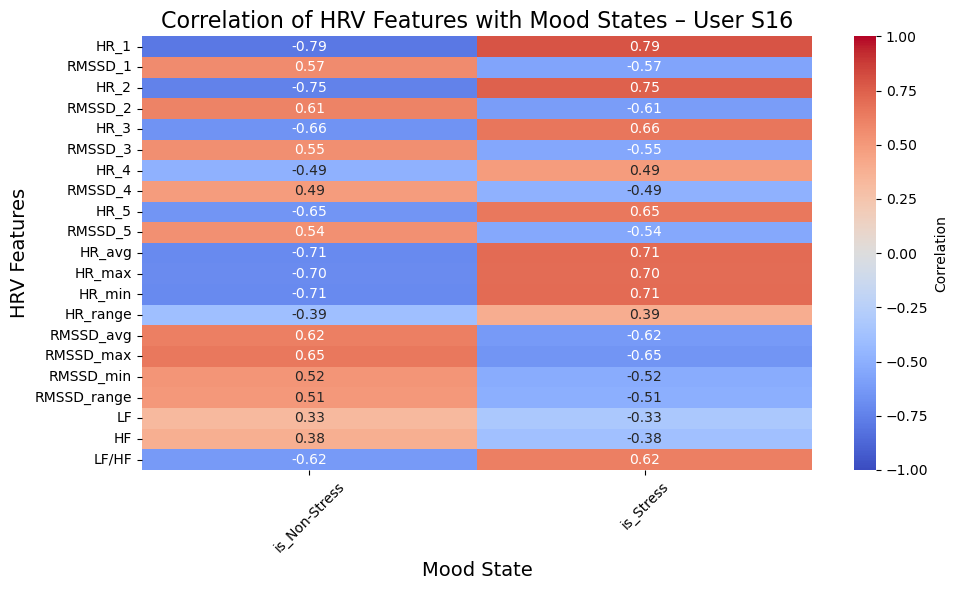

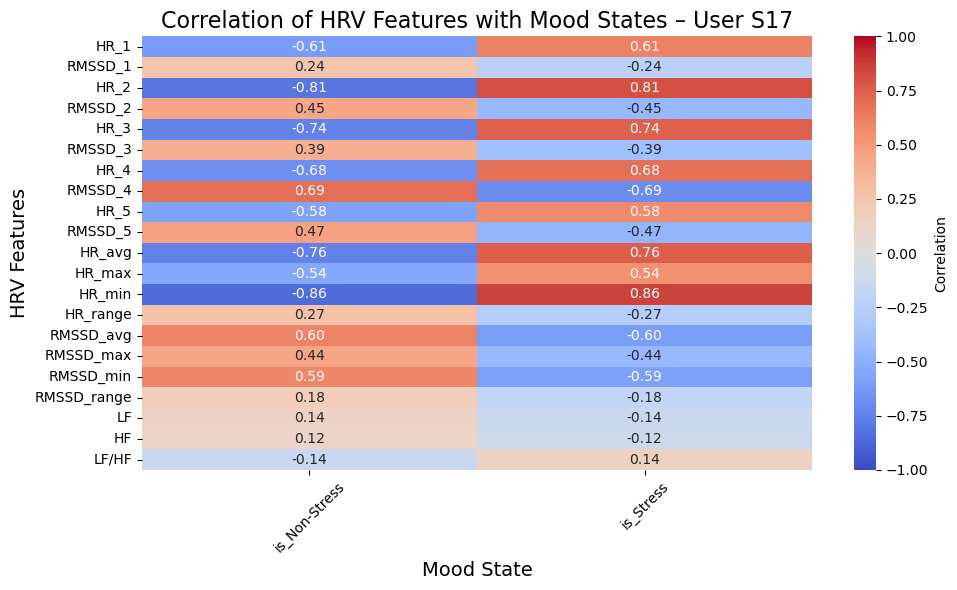

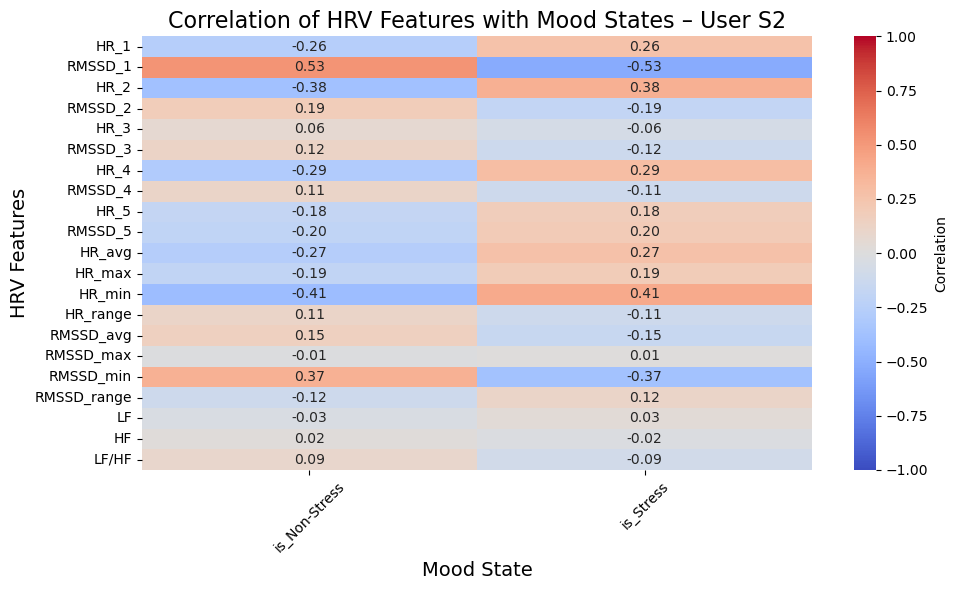

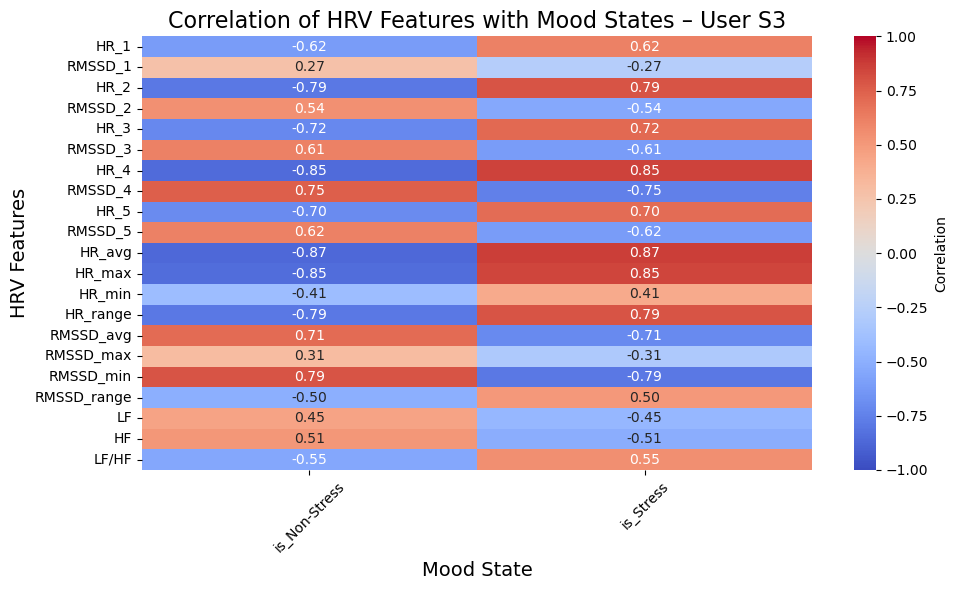

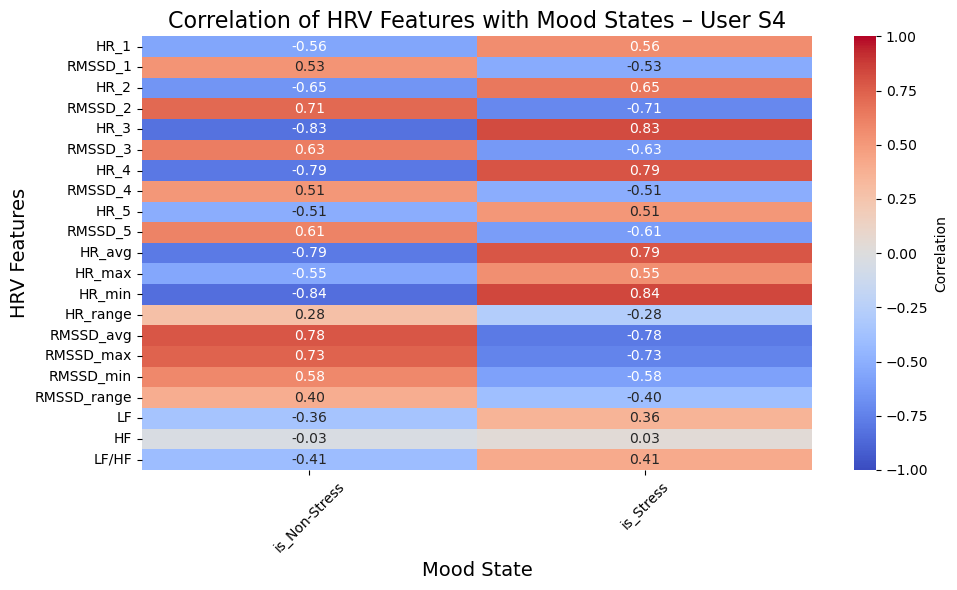

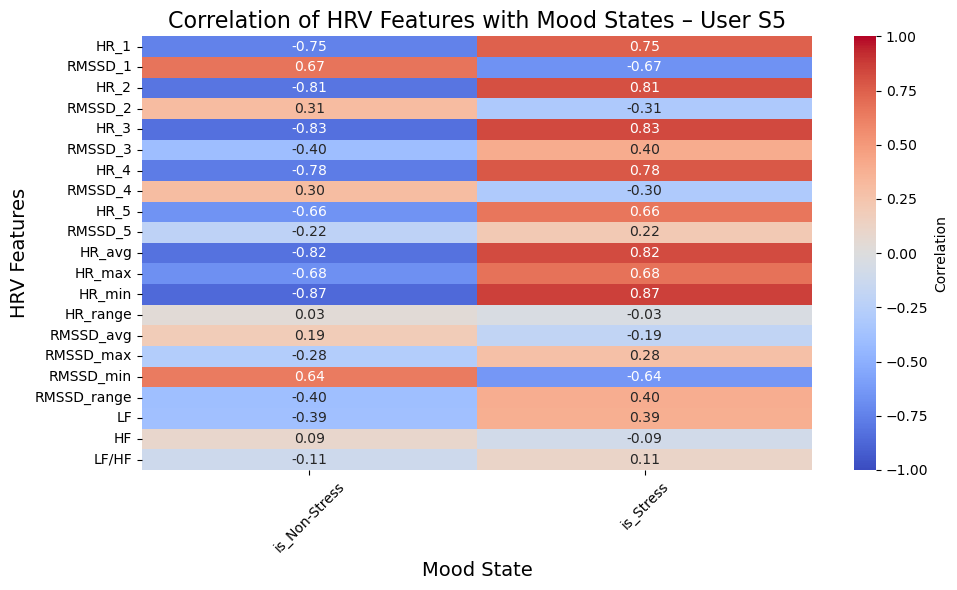

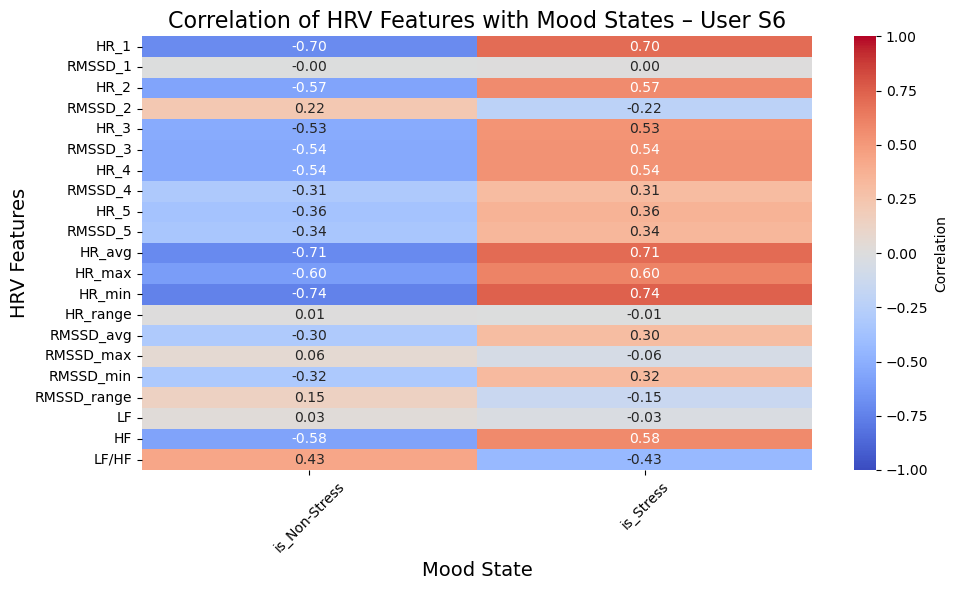

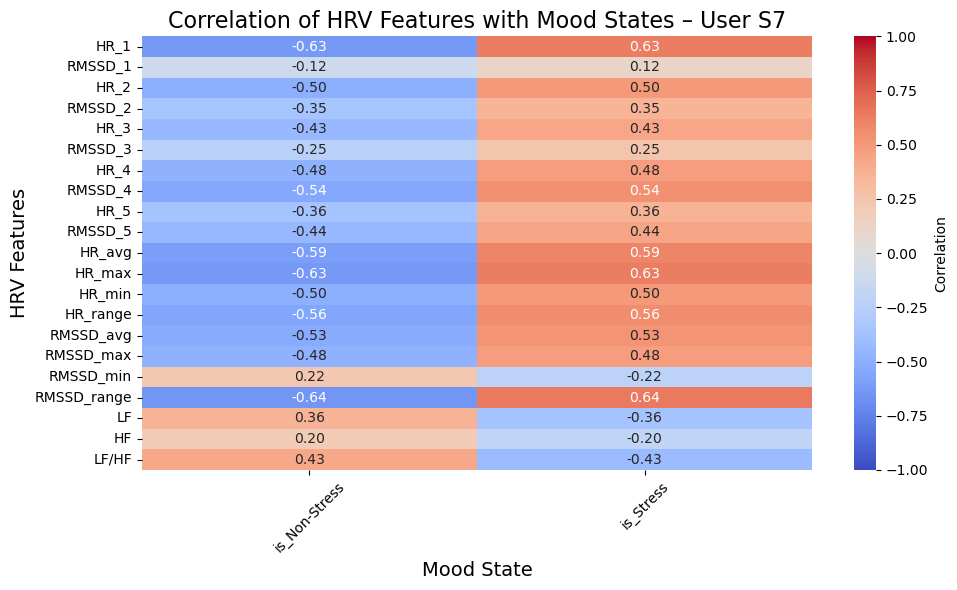

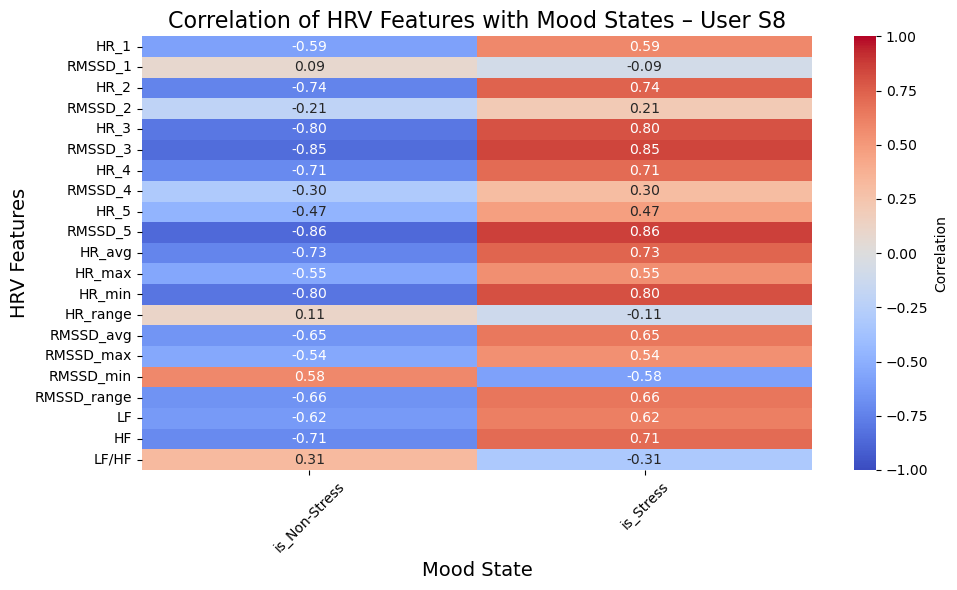

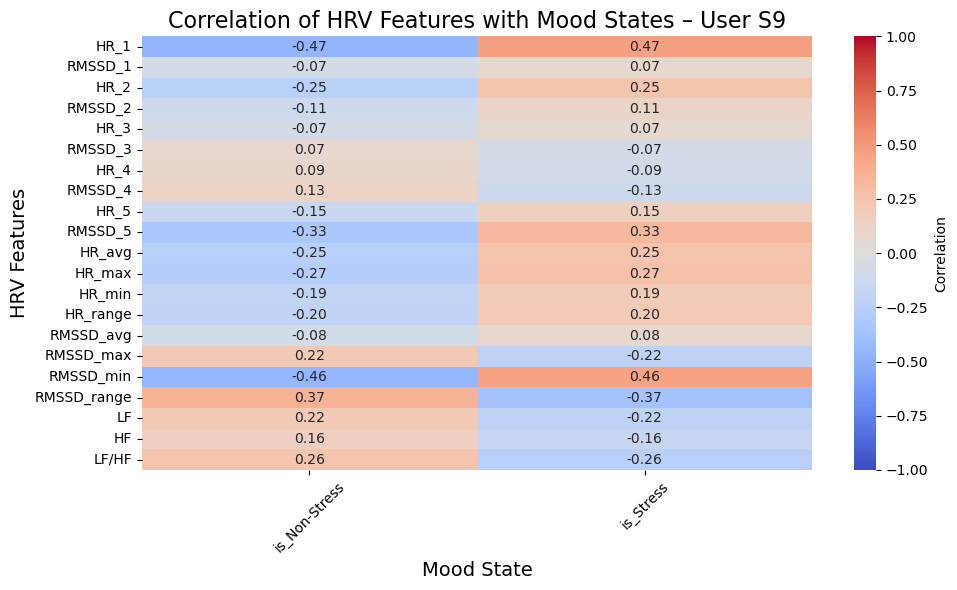

In [8]:
# Map numeric labels to mood names
label_names = {0: 'Non-Stress', 1: 'Stress'}
df_filtered['mood_name'] = df_filtered['label'].map(label_names)

# One-hot encode mood labels
df_ohe = pd.get_dummies(df_filtered['mood_name'], prefix='is')
df_filtered = pd.concat([df_filtered, df_ohe], axis=1)

# HRV features to analyze (all HR/RMSSD columns + LF, HF, LF/HF + averages)
hrv_features = [col for col in df_filtered.columns if col.startswith('HR_') or col.startswith('RMSSD_')] \
               + ['LF', 'HF', 'LF/HF']

# Mood columns (binary)
mood_cols = df_ohe.columns.tolist()

# Unique users
users = df_filtered['user_id'].unique()

for user in users:
    df_user = df_filtered[df_filtered['user_id'] == user]

    # Compute correlation between HRV features and mood states
    corr_matrix = df_user[hrv_features + mood_cols].corr().loc[hrv_features, mood_cols]

    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f",
                cmap="coolwarm", center=0, vmin=-1, vmax=1,
                cbar_kws={'label': 'Correlation'})
    
    plt.title(f'Correlation of HRV Features with Mood States – User {user}', fontsize=16)
    plt.xlabel('Mood State', fontsize=14)
    plt.ylabel('HRV Features', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [9]:
# Features: all HR, RMSSD columns + LF, HF, LF/HF + HR/RMSSD averages + max/min/range
feature_cols = [col for col in df_filtered.columns if col.startswith('HR_') or col.startswith('RMSSD_')] \
               + ['LF', 'HF', 'LF/HF']

# Target
target_col = 'label'

# Unique users
users = df_filtered['user_id'].unique()

# Iterate over users to separate features and labels
for user in users:
    df_user = df_filtered[df_filtered['user_id'] == user]
    
    X = df_user[feature_cols]  # Features
    y = df_user[target_col]    # Target labels
    
    print(f"User {user}: X shape = {X.shape}, y shape = {y.shape}")

User S10: X shape = (12, 21), y shape = (12,)
User S11: X shape = (14, 21), y shape = (14,)
User S13: X shape = (14, 21), y shape = (14,)
User S14: X shape = (14, 21), y shape = (14,)
User S15: X shape = (13, 21), y shape = (13,)
User S16: X shape = (13, 21), y shape = (13,)
User S17: X shape = (15, 21), y shape = (15,)
User S2: X shape = (16, 21), y shape = (16,)
User S3: X shape = (16, 21), y shape = (16,)
User S4: X shape = (18, 21), y shape = (18,)
User S5: X shape = (16, 21), y shape = (16,)
User S6: X shape = (20, 21), y shape = (20,)
User S7: X shape = (13, 21), y shape = (13,)
User S8: X shape = (14, 21), y shape = (14,)
User S9: X shape = (14, 21), y shape = (14,)



--- LOUO: Testing on user S10 ---


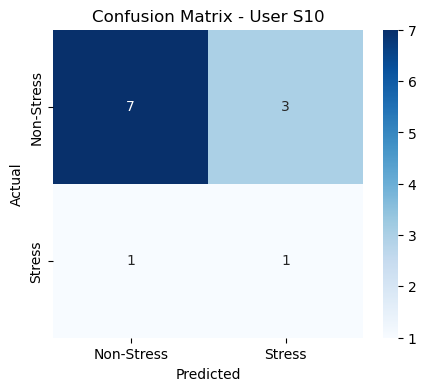


--- LOUO: Testing on user S11 ---


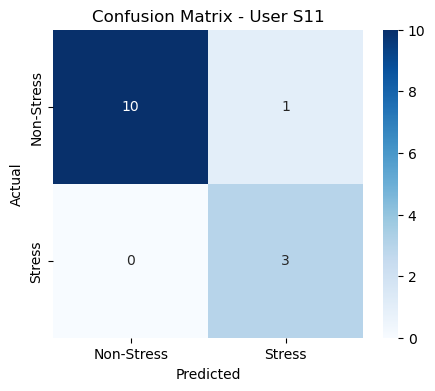


--- LOUO: Testing on user S13 ---


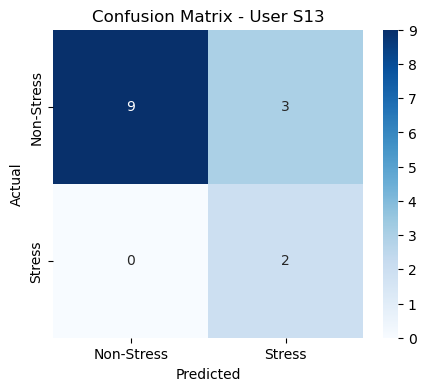


--- LOUO: Testing on user S14 ---


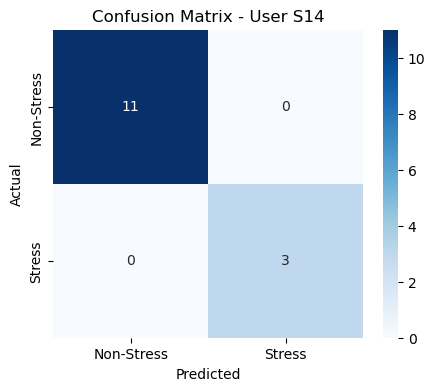


--- LOUO: Testing on user S15 ---


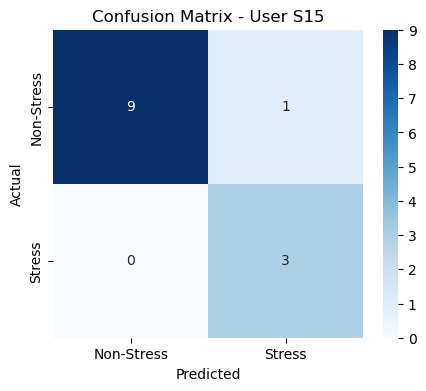


--- LOUO: Testing on user S16 ---


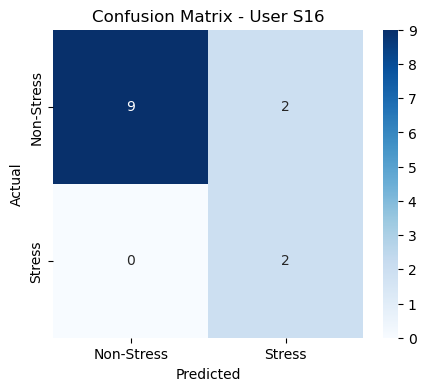


--- LOUO: Testing on user S17 ---


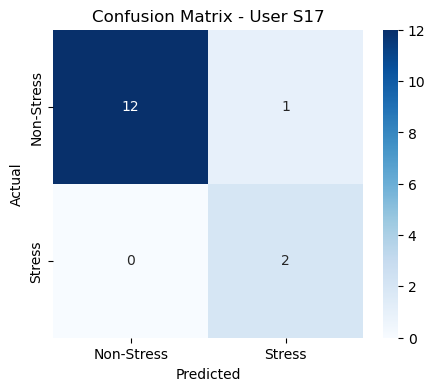


--- LOUO: Testing on user S2 ---


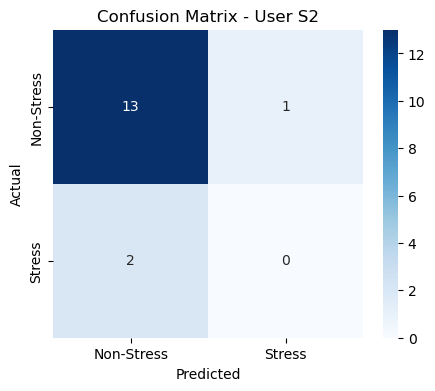


--- LOUO: Testing on user S3 ---


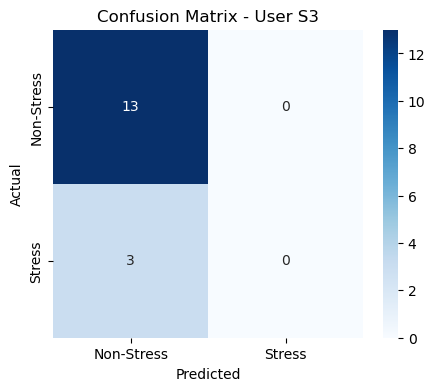


--- LOUO: Testing on user S4 ---


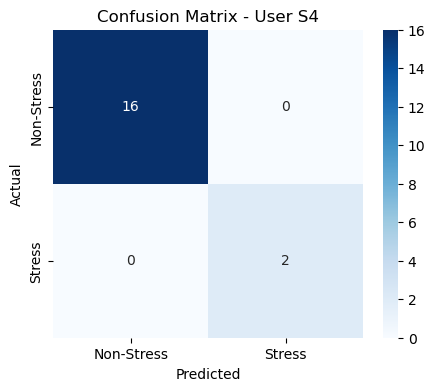


--- LOUO: Testing on user S5 ---


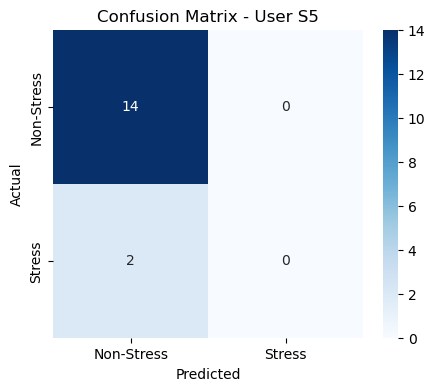


--- LOUO: Testing on user S6 ---


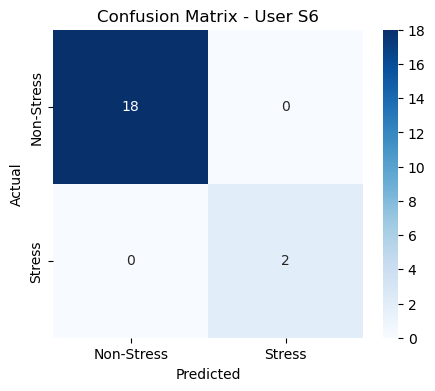


--- LOUO: Testing on user S7 ---


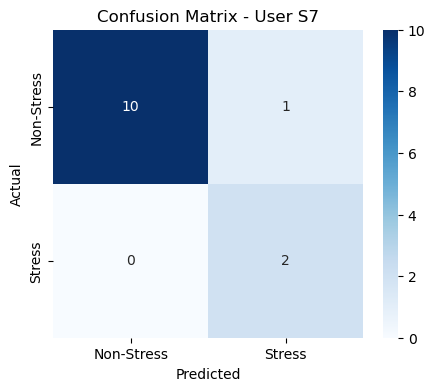


--- LOUO: Testing on user S8 ---


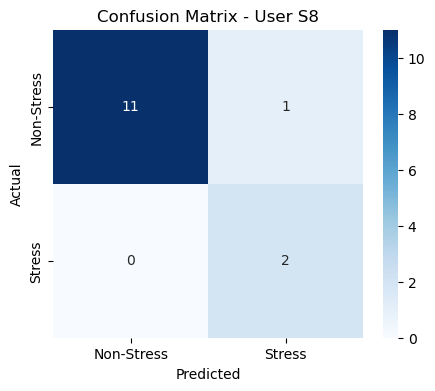


--- LOUO: Testing on user S9 ---


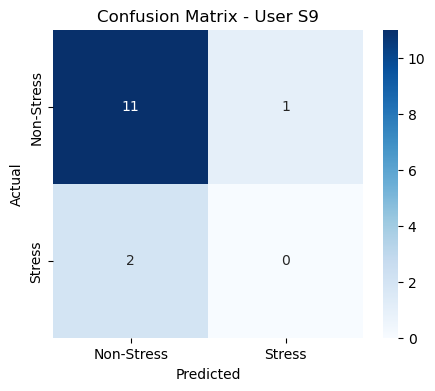

   user  accuracy  precision  f1_score
0   S10  0.666667   0.770833  0.703704
1   S11  0.928571   0.946429  0.931973
2   S13  0.785714   0.914286  0.816327
3   S14  1.000000   1.000000  1.000000
4   S15  0.923077   0.942308  0.926547
5   S16  0.846154   0.923077  0.864103
6   S17  0.933333   0.955556  0.938667
7    S2  0.812500   0.758333  0.784483
8    S3  0.812500   0.660156  0.728448
9    S4  1.000000   1.000000  1.000000
10   S5  0.875000   0.765625  0.816667
11   S6  1.000000   1.000000  1.000000
12   S7  0.923077   0.948718  0.928938
13   S8  0.928571   0.952381  0.934161
14   S9  0.785714   0.725275  0.754286


In [10]:
users = df_filtered['user_id'].unique()
louo_results_xgb = []

for test_user in users:
    print(f"\n--- LOUO: Testing on user {test_user} ---")
    
    # Split train/test by user
    df_train = df_filtered[df_filtered['user_id'] != test_user]
    df_test = df_filtered[df_filtered['user_id'] == test_user]

    X_train, y_train = df_train[feature_cols].values, df_train[target_col].values
    X_test, y_test = df_test[feature_cols].values, df_test[target_col].values

    # Apply SMOTE to balance training set
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Standard scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_res)
    X_test_scaled = scaler.transform(X_test)

    # Train XGBoost classifier
    xgb_model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
    xgb_model.fit(X_train_scaled, y_train_res)

    # Predict on test user
    y_pred = xgb_model.predict(X_test_scaled)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    louo_results_xgb.append({
        "user": test_user,
        "accuracy": acc,
        "precision": prec,
        "f1_score": f1
    })

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Stress','Stress'],
                yticklabels=['Non-Stress','Stress'])
    plt.title(f'Confusion Matrix - User {test_user}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Results dataframe
louo_results_xgb_df = pd.DataFrame(louo_results_xgb)
print(louo_results_xgb_df)

In [11]:
# Compute weighted averages across all users
precision = np.mean([r['precision'] for r in louo_results_xgb])
accuracy  = np.mean([r['accuracy'] for r in louo_results_xgb])
f1        = np.mean([r['f1_score'] for r in louo_results_xgb])

print("LOUO-CV Results (Weighted Avg across all users):")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"F1-score:  {f1:.3f}")

LOUO-CV Results (Weighted Avg across all users):
Accuracy:  0.881
Precision: 0.884
F1-score:  0.875



General XGBoost Model Evaluation on Test Users:
Accuracy:  0.860
Precision: 0.826
F1-score:  0.837

Detailed Classification Report:
              precision    recall  f1-score   support

  Non-Stress       0.89      0.96      0.92        75
      Stress       0.40      0.18      0.25        11

    accuracy                           0.86        86
   macro avg       0.64      0.57      0.59        86
weighted avg       0.83      0.86      0.84        86



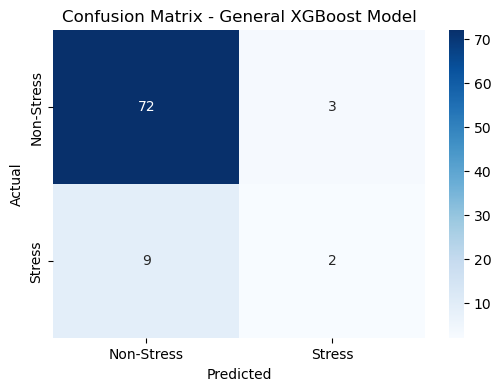

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# Features: all HR/RMSSD columns + LF, HF, LF/HF + averages
feature_cols = [col for col in df_filtered.columns if col.startswith('HR_') or col.startswith('RMSSD_')] \
               + ['LF', 'HF', 'LF/HF']
target_col = 'label'

# Train/test split by users
train_users = ['S7','S8','S9','S10','S13','S14','S15','S16','S17','S11'] 
test_users  = ['S2','S3','S4','S5','S6']                   

df_train = df_filtered[df_filtered['user_id'].isin(train_users)]
df_test  = df_filtered[df_filtered['user_id'].isin(test_users)]

X_train, y_train = df_train[feature_cols].values, df_train[target_col].values
X_test, y_test = df_test[feature_cols].values, df_test[target_col].values

# Apply SMOTE to balance classes in training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Train general XGBoost classifier
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train_scaled, y_train_res)

# Predict on test set
y_pred = xgb_model.predict(X_test_scaled)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("\nGeneral XGBoost Model Evaluation on Test Users:")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"F1-score:  {f1:.3f}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred,
                            target_names=['Non-Stress','Stress'],
                            zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Stress','Stress'],
            yticklabels=['Non-Stress','Stress'])
plt.title('Confusion Matrix - General XGBoost Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Classification Report on Real Test Set:
              precision    recall  f1-score   support

           0       0.87      0.72      0.79     22132
           1       0.35      0.58      0.44      5702

    accuracy                           0.69     27834
   macro avg       0.61      0.65      0.61     27834
weighted avg       0.76      0.69      0.72     27834



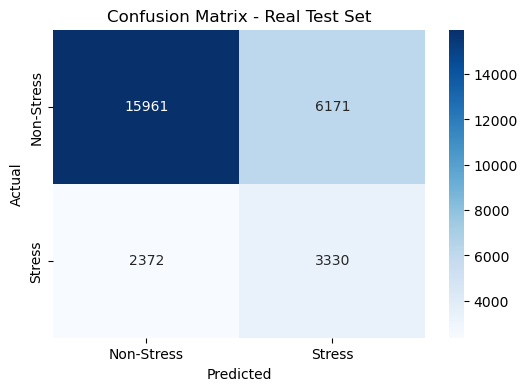

In [28]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Load datasets ===
# Training dataset is already loaded as `df`
real_test_file = "synthetic_hrv_combined.csv" 
df_real_test = pd.read_csv(real_test_file)

# === Step 2: Identify HR and RMSSD columns ===
hr_cols_train = [col for col in df.columns if col.startswith("HR_")]
rmssd_cols_train = [col for col in df.columns if col.startswith("RMSSD_")]

hr_cols_test = [col for col in df_real_test.columns if col.startswith("HR_")]
rmssd_cols_test = [col for col in df_real_test.columns if col.startswith("RMSSD_")]

# === Step 3: Compute HR & RMSSD summary features for training data ===
# HR features
df["HR_avg"] = df[hr_cols_train].mean(axis=1)
df["HR_max"] = df[hr_cols_train].max(axis=1)
df["HR_min"] = df[hr_cols_train].min(axis=1)
df["HR_range"] = df["HR_max"] - df["HR_min"]

# RMSSD features
df["RMSSD_avg"] = df[rmssd_cols_train].mean(axis=1)
df["RMSSD_max"] = df[rmssd_cols_train].max(axis=1)
df["RMSSD_min"] = df[rmssd_cols_train].min(axis=1)
df["RMSSD_range"] = df["RMSSD_max"] - df["RMSSD_min"]

# === Step 4: Compute HR & RMSSD summary features for real test data ===
# HR features
df_real_test["HR_avg"] = df_real_test[hr_cols_test].mean(axis=1)
df_real_test["HR_max"] = df_real_test[hr_cols_test].max(axis=1)
df_real_test["HR_min"] = df_real_test[hr_cols_test].min(axis=1)
df_real_test["HR_range"] = df_real_test["HR_max"] - df_real_test["HR_min"]

# RMSSD features
df_real_test["RMSSD_avg"] = df_real_test[rmssd_cols_test].mean(axis=1)
df_real_test["RMSSD_max"] = df_real_test[rmssd_cols_test].max(axis=1)
df_real_test["RMSSD_min"] = df_real_test[rmssd_cols_test].min(axis=1)
df_real_test["RMSSD_range"] = df_real_test["RMSSD_max"] - df_real_test["RMSSD_min"]

# === Step 5: Select features used in training ===
feature_cols = [col for col in df.columns if col.startswith('HR_') or col.startswith('RMSSD_')] \
               + ['LF', 'HF', 'LF/HF']

X_real = df_real_test[feature_cols].values
y_real = df_real_test["label"].values  # optional if ground truth exists

# === Step 6: Scale features using the scaler fitted on training data ===
X_real_scaled = scaler.transform(X_real)

# === Step 7: Predict using the trained XGBoost classifier ===
y_pred = xgb_model.predict(X_real_scaled)

# Optional: predicted probabilities
# y_pred_proba = xgb_model.predict_proba(X_real_scaled)[:,1]

# === Step 8: Evaluate (if ground truth exists) ===
print("\nClassification Report on Real Test Set:")
print(classification_report(y_real, y_pred, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_real, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Stress','Stress'],
            yticklabels=['Non-Stress','Stress'])
plt.title("Confusion Matrix - Real Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
